In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import fractions

In [2]:
class Bandit:
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial
    
    def reset(self):
        self.q_true = np.random.randn(self.k) + self.true_reward
        self.q_estimation = np.zeros(self.k) + self.initial
        self.action_count = np.zeros(self.k)
        self.best_action = np.argmax(self.q_true)
        self.time = 0
        
    def sampling(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices) # choose a bandit arm (0~9)
        
        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])
        
        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)
        
        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])
    
    def step(self, action):
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time
        
        if self.sample_averages:
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

In [3]:
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.sampling()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

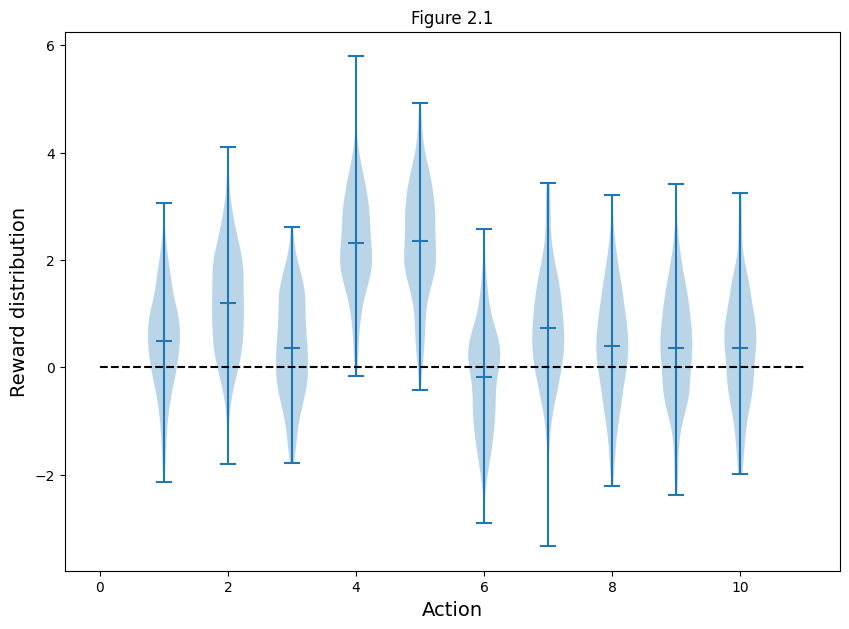

In [22]:
def figure_2_1():
    plt.figure(figsize=(10, 7))
    plt.violinplot(dataset=np.random.randn(200, 10) + np.random.randn(10), showmeans=True)
    plt.plot([0, 11], [0, 0], 'k--')
    plt.xlabel('Action', fontsize=14)
    plt.ylabel('Reward distribution', fontsize=14)
    plt.title('Figure 2.1')
    
figure_2_1()

In [28]:
epsilons = [0, 0.1, 0.01]

def figure_2_2(runs=2000, time=1000):
    bandits = [Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
    best_action_counts, rewards = simulate(runs, time, bandits)
    return best_action_counts, rewards
    
best_action_counts, rewards = figure_2_2()

100%|██████████| 2000/2000 [00:23<00:00, 85.35it/s]


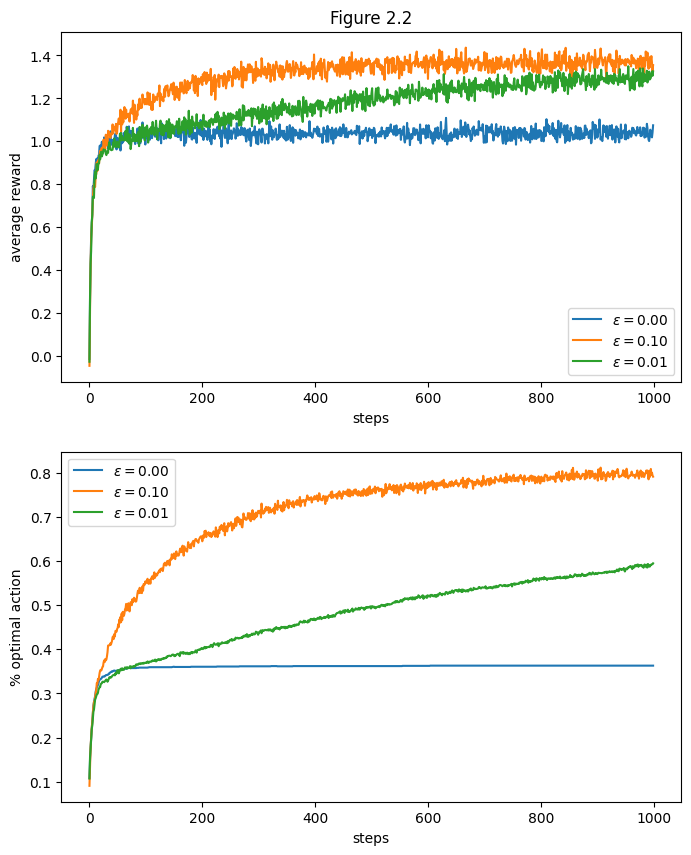

In [30]:
plt.figure(figsize=(8, 10))

plt.subplot(2, 1, 1)
for eps, reward in zip(epsilons, rewards):
    plt.plot(reward, label='$\epsilon = %.02f$' % (eps))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.title('Figure 2.2')
plt.legend()

plt.subplot(2, 1, 2)
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts, label='$\epsilon = %.02f$' % (eps))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()
plt.show()


In [31]:
def figure_2_3(runs=2000, time=1000):
    bandits = []
    bandits.append(Bandit(epsilon=0, initial=5, step_size=0.1))
    bandits.append(Bandit(epsilon=0.1, initial=0, step_size=0.1))
    bandits.append(Bandit(epsilon=0.1, initial=5, step_size=0.1))
    best_action_counts, _ = simulate(runs, time, bandits)
    return best_action_counts
    
best_action_counts = figure_2_3()

100%|██████████| 2000/2000 [00:23<00:00, 85.33it/s]


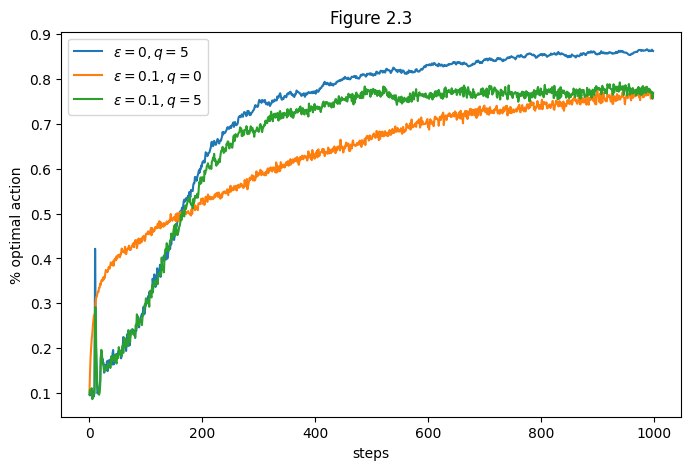

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(best_action_counts[0], label='$\epsilon = 0, q =5$')
plt.plot(best_action_counts[1], label='$\epsilon = 0.1, q=0$')
plt.plot(best_action_counts[2], label='$\epsilon = 0.1, q=5$')
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.title('Figure 2.3')
plt.legend()
plt.show()

In [33]:
def figure_2_4(runs=2000, time=1000):
    bandits = []
    bandits.append(Bandit(epsilon=0, UCB_param=2, sample_averages=True))
    bandits.append(Bandit(epsilon=0.1, sample_averages=True))
    _, average_rewards = simulate(runs, time, bandits)
    return average_rewards

average_rewards = figure_2_4()

100%|██████████| 2000/2000 [00:22<00:00, 88.43it/s]


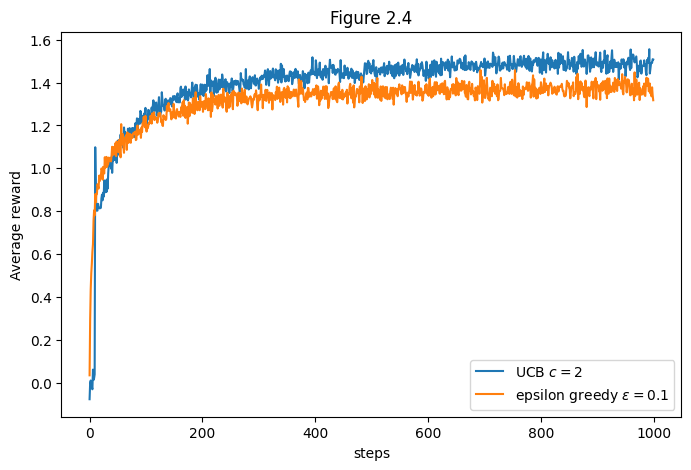

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(average_rewards[0], label='UCB $c = 2$')
plt.plot(average_rewards[1], label='epsilon greedy $\epsilon = 0.1$')
plt.xlabel('steps')
plt.ylabel('Average reward')
plt.title('Figure 2.4')
plt.legend()
plt.show()

In [35]:
def figure_2_5(runs=2000, time=1000):
    bandits = []
    bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=False, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=True, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=False, true_reward=4))
    best_action_counts, _ = simulate(runs, time, bandits)
    labels = [r'$\alpha = 0.1$, with baseline', 
              r'$\alpha = 0.1$, without baseline', 
              r'$\alpha = 0.4$, with baseline',
              r'$\alpha = 0.4$, without baseline']
    return bandits, best_action_counts, labels

bandits, best_action_counts,labels = figure_2_5()

100%|██████████| 2000/2000 [00:38<00:00, 51.45it/s]


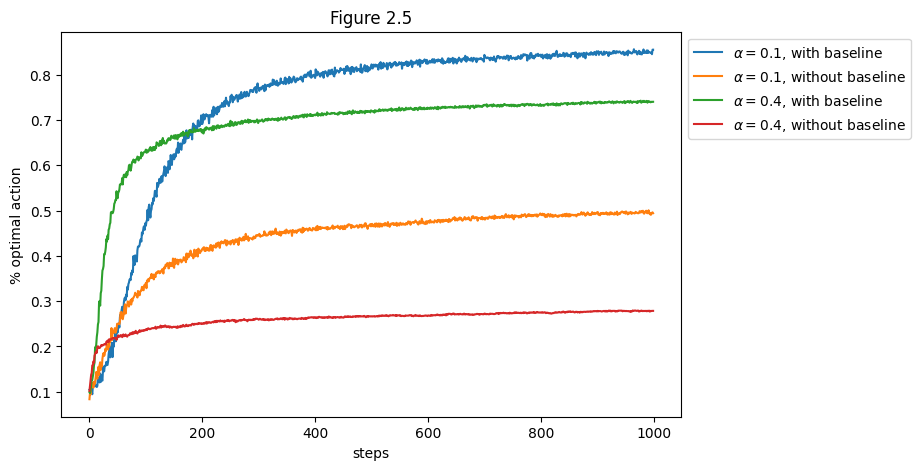

In [36]:
plt.figure(figsize=(8, 5))
for i in range(len(bandits)):
    plt.plot(best_action_counts[i], label=labels[i])
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.title('Figure 2.5')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [37]:
labels = ['epsilon-greedy', 'gradient bandit', 'UCB', 'optimal initialization']

def figure_2_6(runs=2000, time=1000):
    generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
                  lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
                  lambda coef: Bandit(epsilon=0, UCB_param=coef, sample_averages=True),
                  lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1)]
    parameters = [np.arange(-7, -1, dtype=np.float64),
                  np.arange(-5, 2, dtype=np.float64), 
                  np.arange(-4, 3, dtype=np.float64), 
                  np.arange(-2, 3, dtype=np.float64)]

    bandits = []
    for generator, parameter in zip(generators, parameters):
        for param in parameter:
            bandits.append(generator(pow(2, param)))
    
    _, average_rewards = simulate(runs, time, bandits)
    rewards = np.mean(average_rewards, axis=1)

    return parameters, rewards

parameters, rewards = figure_2_6()

100%|██████████| 2000/2000 [00:24<00:00, 81.75it/s]


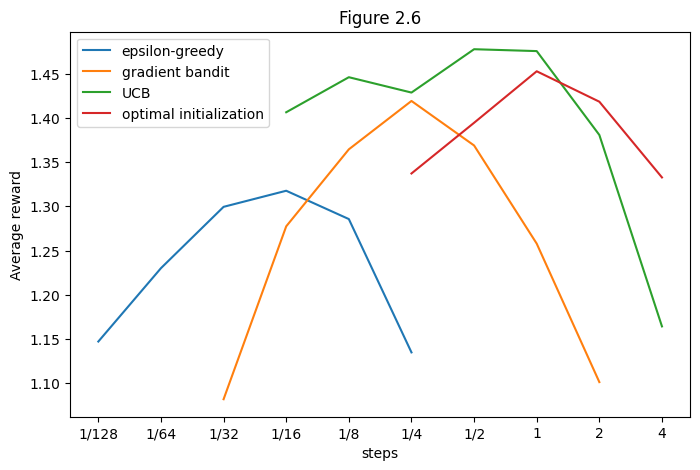

In [76]:
ticks = pow(2, np.arange(-7, 3, dtype=np.float64))
plt.figure(figsize=(8, 5))

i = 0
for label, param in zip(labels, parameters):
    length = len(param)
    plt.plot(pow(2, param), rewards[i:i+length], label=label)
    i += length

plt.xscale("log")
plt.minorticks_off()
plt.xticks(ticks, [str(fractions.Fraction(tick)) for tick in ticks])
plt.xlabel('steps')
plt.ylabel('Average reward')
plt.title('Figure 2.6')
plt.legend()
plt.show()